In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame
from scipy.stats import norm
from numpy.random import normal, multivariate_normal

# EMアルゴリズムの概要
* 教師なし学習によるクラスタリングのアルゴリズム
* 確率モデルのパラメータを最尤推定する手法の一つ
* 尤度の期待値を最大化するようなパラメータを求めるためにk平均法のように反復して計算する

# EMアルゴリズムを用いて今回やること

手書き文字を分類する。以下のステップで実行される

1. 手書きサンプルから代表文字の生成 (ベルヌーイ分布を用いた最尤推定法)
2. 複数の文字が混在した手書き文字サンプルの分類(混合ベルヌ−イ分布を用いた最尤推定法 <- EMアルゴリズムを使う)

# 1. 手書きサンプルから代表文字の生成

## 概略

1. 平均化による代表文字の生成
2. ベルヌーイ分布を用いた最尤推定法による代表文字の生成
3. 1と２は結果的に同じになる

## 平均化による代表文字の生成
各手書き画像(トレーニングセット)のピクセルを横一列に並べて色(黒白)を1,0で表したベクトルを用意する
 (文字データはモノクロ2段調)
n番目の画像に対応するベクトルをXnとすると第i成分 [Xn]i を見るとi番目のピクセルの色が分かる。これらの平均を取れば、特定の数字の各i成分目を平均化したベクトルμを用意できる。

$$ \mu = \frac{1}{N} \Sigma_{n=1}^{N}x_n $$  (7.1)

## ベルヌーイ分布を用いた最尤推定法による代表文字の生成
ランダムに手書き文字を生成する**画像生成器** があるとする。これは、下記のような濃淡のあるような文字を生成するとする。

[![https://gyazo.com/c8b7471de8a3cc39fc9d9a714c33e6e4](https://i.gyazo.com/c8b7471de8a3cc39fc9d9a714c33e6e4.png)](https://gyazo.com/c8b7471de8a3cc39fc9d9a714c33e6e4)

* 上記の画像のピクセルの濃淡を0~1で表わし(ベクトルμ)、「生成される画像のi番目のピクセルを黒にする」確立として考えると、ランダムな画像を生成することができる。この時、ベクトルμを**画像生成器**とを生成することができる。
* では、どのような画像生成器を選べばいいのか？　
* それはトレーニングセット（内の特定の数字のデータ）と、画像生成器が生成する数字が同じになる確率が最大化する画像生成器を選出する。
* これをするのが**ベルヌーイ分布**になる

* ある特定の画像データxのi番目(1~D)のピクセルの色(0 or 1)が得られる確立をp_iとすると、p_iは下記の条件が成り立つ必要がある。
$$ i番目のピクセルが黒の場合(x_i = 1): p_i = \mu_i$$
$$ i番目のピクセルが黒の場合(x_i = 0): p_i = 1 - \mu_i$$

* 上記の条件は下記の式で表すことができる (**ベルヌーイ分布**)
$$ p_i = \mu_{i} ^{x_i}(1-\mu_i)^{1-x_i} $$

* 従って、全ピクセルについて同じ色に成る確立は以下のとおり
$$ p(x) = \Pi_{i=1}^{D}p_i = \Pi_{i=1}^{D}\mu_{i}^{x_i}(1-\mu_i)^{1-x_i} $$

* 更に特定の数字の全トレーニングせっとに一致する画像が得られる確立配下の通り (**尤度関数**)
$$ P = \Pi_{n=1}^{N}p(x_n) = \Pi^{N}_{n=1}\Pi_{i=1}^{D}\mu_{i}^{{[x_n]}_i}(1-\mu_i)^{1-{{[x_n]}_i} $$
        
* 上記のPが最大化するむー      

## 2. 複数の文字が混在した手書き文字サンプルの分類

### 概略

* 混合ベルヌーイ分布を用いて最尤推定法を実施する
 * ここでEMアルゴリズムが必要になる
* 複数の手描き文字データが混合している時に文字の種類ごとに分類する方法を説明する内容

### 手順

全部でK種類の数字を含む手描き文字画像のトレーニングセットがあり、1. と同様に画像生成器をK個用意して、K個の画像生成器を {uk} k=1 → Kとすると、特定の画像生成器ukから画像xが得られる確率は(7.5)同様に以下で表せる

<img width="" alt="97cde082df52da0c5aafc72fa4c31278_90_black.png (1.1 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/8646fa79-dcad-4a84-8967-20cf40bc7118.png"> (7.10)

どの画像生成器を使うかによって確率が変わるが、使用する画像生成器の選択にも確率を取り入れ、どれか1つの画像生成器をランダンムに選択して、新しい画像を生成する操作を行う
k番目の画像生成器を選ぶ確率をπkとすると{πk} k=1 →Kは次の条件を満たす

<img alt="632734b224cae097b7a897526c7290e5_90_black.png (551 B)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/f83f437d-1187-47bf-88bc-2f7deef19bf7.png"> (7.11)

特定の画像xが得られる確率は以下で表される

<img alt="264074e1d0cdd5541904c2102eb59ee0_90_black.png (841 B)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/3231ac0e-d365-4e1a-87c1-65ed34208830.png"> (7.12)

トレーニングセットにh区生まれるデータ数をNとして、上記の操作をN回繰り返したとするとNこの画像がトレーニングセットのデータ群と一致する確率は以下で表される

<img width="198" alt="eabfda9b2f5f0a99abc81f654f743fea_90_black.png (1.3 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/6ecac89f-449c-4f74-8e32-86399ea23d75.png"> (7.13)

上記がこのモデルの尤度関数となる
尤度関数のパラメータは、各画像生成器を表すベクトル{μk} k=1→Kと、各画像生成器を選択する確率{πk}k=1 →Kとなる
各画像生成器の確率がベルヌーイ分布のため、混合ベルヌーイ分布となる

(7.13)の尤度関数を最大化するパラメータを決定したいが積と和の計算が混在しているため対数尤度関数にしても計算できない、ここでEMアルゴリズムを使って尤度関数を最大化するパラメータを求める
手法としてはk平均方に類似している

まずK個の画像生成器{μk} k=1→を適当に用意する
これはk平均方における代表点を適当に設定する操作に相当する

(7.12)からk番目の画像生成器が選択されて画像Xnが生成される確率は以下となる

<img alt="c8c4fd34f94d8a77c111cc1e1484269c_90_black.png (915 B)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/2fe398c3-de0f-48c7-9eef-6d5c6901c26a.png"> (7.14)

上記は全てのkの合計値となるが、どの画像生成器が選択された場合でもXnと同じ画像が生成される可能性がある
特定のk番目の画像生成器から画像Xnが得られる割合は以下になります

<img alt="3048c687d044f69bc9d9569dc073b738_90_black.png (1.1 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/488753ad-0cd5-4338-b8a5-5b30cfdff5c1.png"> (7.15)

上記は、k平均方におけるトレーニングセットに含まれるデータXnが所属する代表点を決める操作に相当する

k平均方では最も近い代表点に所属するという条件で変数を設定したが、この場合ではXnはどれか1つでなく各画像生成器に対してγnkの割合で所属するため、その割合に基づいて画像生成器{μk} k=1→Kと画像生成器を選択する確率{πk}k=1→Kを計算する

<img alt="4543f24280c14d88bcd7ef034ed32e3b_90_black.png (946 B)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/275da68f-e396-4dce-b949-4bebe518afef.png"> (7.16)

<img alt="559285d12e30d01f96fa2e16f8b6890e_90_black.png (651 B)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/08/6378/fcb1a4b3-d204-478f-8922-ac044d5af1b3.png"> (7.17)

上記はk平均法における各クラスターの重心として新たな代表点を取り直す操作に相当する

これでEMアルゴリズムの手続きは完成し、(7.16),(7.17)で決まる{μk} k=1→K, {πk}k=1→Kを使って(7.15)でγnkを求め、同じように繰り返すと(7.13)の尤度関数の値が大きくなり、最終的に極大値に達する

k平均法と同じ性質で、あくまで最大値を求めるものではなく極大値が求まるものであり、最初に用意する{μk} k=1→K, {πk}k=1→Kで結果が変わる可能性がある

### サンプル

#### 0,3,6による分類

1. 画像生成器の更新
<img width="576" alt="figure_1.png (72.4 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/c1b315fb-b078-4ebb-bfd8-aa4fe066d489.png">

2. 最終画像生成器による手書き文字分類結果
<img width="576" alt="figure_2.png (54.4 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/72a97d6b-3557-47ce-82f6-c139e4692640.png">

#### 0, 1, 3, 5, 6による分類

1. 画像生成器の更新
<img width="576" alt="figure_1-2.png (104.7 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/a72aa28b-86b1-46e9-9231-7381590bfaeb.png">

2. 最終画像生成器による手書き文字分類結果
<img width="576" alt="figure_2-2.png (75.8 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/bcaf2bda-ecd8-452d-b98a-8403ab5d1fef.png">

#### 0 ~ 10による分類

1. 画像生成器の更新
<img width="576" alt="figure_1-3.png (163.9 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/2c57780e-84cd-4ebc-9e1c-c0a6426145b9.png">

2. 最終画像生成器による手書き文字分類結果
<img width="576" alt="figure_2-3.png (71.6 kB)" src="https://files.esa.io/uploads/production/attachments/2264/2016/05/06/6378/ddb7d8d3-bcd1-42ef-8bfc-262e7ae6cfa8.png">

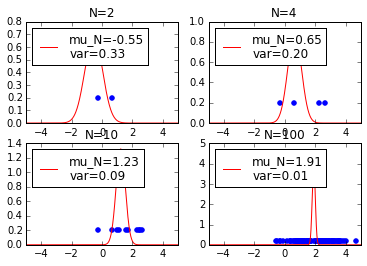

In [30]:
# 真の分布
mu_true = 2.0
beta_true = 1.0

# 事前分布
mu_0 = -2.0
beta_0 = 1.0

fig1 = plt.figure()
ds = normal(loc=mu_true, scale=1.0/beta_true, size=100)

for c, n in enumerate([2,4,10,100]): # トレーニングセットのデータ数
    trainset = ds[0:n]
    mu_ML = np.mean(trainset)
    mu_N = (beta_true*mu_ML + beta_0*mu_0/n)/(beta_true+beta_0/n)
    beta_N = beta_0 + n*beta_true

# 平均μの推定結果を表示
    subplot = fig1.add_subplot(2,2,c+1)
    subplot.set_title("N=%d" % n)
    linex = np.arange(-10,10.1,0.01)

    # 平均μの確率分布
    sigma = 1.0/beta_N
    mu_est = norm(loc=mu_N, scale=np.sqrt(sigma))
    label = "mu_N=%.2f\nvar=%.2f" % (mu_N, sigma)
    subplot.plot(linex, mu_est.pdf(linex), color='red', label=label)
    subplot.legend(loc=2)

    # トレーニングセットを表示
    subplot.scatter(trainset, [0.2]*n, marker='o', color='blue')
    subplot.set_xlim(-5,5)
    subplot.set_ylim(0)

fig1.show()

##  ベイズ推定による正規分布の決定 : 観測値の分布の推定
* さまざまなμに対する正規分布N(t | μ, σ^2) をそれぞれの確立P(μ|t)の重みで足し合わせる。式にすると...

$$P(t) = \int_{-\infty}^{\infty} P(\mu | t) N(t | \mu, \sigma^2)du$$

* ここに8.39を代入し、積分を実行すると次の観測値の分布の式が出来上がる

$$ P(t) = N(t | \mu_n, \beta^{}-1 + \beta_N^{-1})$$

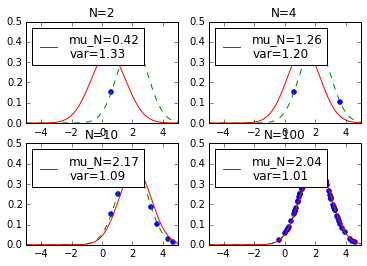

In [32]:
fig2 = plt.figure()
ds = normal(loc=mu_true, scale=1.0/beta_true, size=100)

for c, n in enumerate([2,4,10,100]): # トレーニングセットのデータ数
        trainset = ds[0:n]
        mu_ML = np.mean(trainset)
        mu_N = (beta_true*mu_ML + beta_0*mu_0/n)/(beta_true+beta_0/n)
        beta_N = beta_0 + n*beta_true
        
        # 次に得られるデータの推定分布を表示
        subplot = fig2.add_subplot(2,2,c+1)
        subplot.set_title("N=%d" % n)
        linex = np.arange(-10,10.1,0.01)
        
        # 真の分布を表示
        orig = norm(loc=mu_true, scale=np.sqrt(1.0/beta_true))
        subplot.plot(linex, orig.pdf(linex), color='green', linestyle='--')
        
        # 推定分布を表示
        sigma = 1.0/beta_true+1.0/beta_N
        mu_est = norm(loc=mu_N, scale=np.sqrt(sigma))
        label = "mu_N=%.2f\nvar=%.2f" % (mu_N, sigma)
        subplot.plot(linex, mu_est.pdf(linex), color='red', label=label)
        subplot.legend(loc=2)
        
        # トレーニングセットを表示
        subplot.scatter(trainset, orig.pdf(trainset), marker='o', color='blue')
        subplot.set_xlim(-5,5)
        subplot.set_ylim(0)
        
        fig2.show()

# ベイズ推定の回帰分析への応用
* 1.3.1の「回帰分析による観測値の推測」をベイズ推定にて
        * y =sin(2*pi*x)に標準偏差0.3の正規分布の誤差を加えたデータから、新たな観測値を予測する

## パラメタの事後分布の計算

* 分散は最初からわかっているものとする
$$ f(x) = \sum_{m=0}^{M}w_mx^m	 $$

$$ \sigma^2 = \beta^{-1} $$

$$ N(t | f(x_n), \beta^{-1})  = \sqrt{\frac{\beta}{2\pi}} e^{-\frac{\beta}{2}(t - f(x_n))^2}$$

$$ P(t|w) = \Pi_{n=1}^{N} N(t_n | f(x_n), \sigma^2 = \beta^{-1}) = (\frac{\beta}{2\pi})^\frac{N}{2} exp[-\frac{\beta}{2}\sum_{n=1}^{N}(f(x_n) - t_n)^2]  $$

### 事前分布

* ある程度のデータ数Nがあると想定し、適当に決める(平均0 , 分散1/alpha)
$$ P(w) = N(w | 0, \alpha^{-1}I) = (\frac{\alpha}{2\pi}) ^ {\frac{M+1}{2}} exp(-\frac{\alpha}{2}w^Tw) $$

### 事後分布
* P(t|w)からベイズ定理を用いると以下のとおりになる
    * 分母はパラメタ(w)に依存しないので正規化定数Z(全確率が1になる定数)

$$ P(w|t) = \frac{P(t|w)}{\int_{-\infty}^{\infty}P(t|w')dw'} P(w) = \frac{1}{Z}P(t|w)P(w)$$

* P(w)とP(t|w)を代入すると

$$ P(w|t) = Const * exp[-\frac{\beta}{2}\sum_{n=1}^{N}(f(x_n) - t_n)^2 -\frac{\alpha}{2}w^Tw]$$

* この形を見やすくするには、P(w|t)をwについて平方完成させる必要がある。（**なぜ**)

$$ P(w|t) = N(w |  \beta S\sum_{n=1}^{N}  t_{n} \phi(x_n), S) $$

$$ S^{-1} = \alpha I + \beta\sum_{n=1}{N}\phi(x_n)\phi(x_n)^T$$

$$ \phi(x) =  \left( \begin{array}{ccc}
x^0 \\
x^1 \\
\vdots \\
x^M  \end{array} \right)
$$

## 評価関数（誤差関数）
* 評価関数は以下
* 第二項はオーバーフィッティング対策。事前分布によってwの絶対値があまり大きくならないように抑制し、多項式の値の変動を抑える。
    * ただしαの値の設定によって効果がかわる。
$$ E = \frac{\beta}{2}\sum_{n=1}^{N}\{f(x_n) - t_n\} ^2 + \frac{\alpha}{2}w^{T}w$$

## 観測値の分布の推定
* xから観測値tが得られる確立のさまざまなw、事後分布p(w|t)の重みで足し合わせる。
$$ P(x,t) = \int_{-\inf}^{\inf} P(w|t) N(t | f(x), \beta^{-1}dw$$

* これをゴニョゴニョすると以下の正規分布ができあがる
$$ P(x,t) = N(t|m(x), s(x))$$
$$ 平均: m(x) = \beta\phi(x)^TS\sum_{n=1}^{N}t_n\phi(x_n)$$
$$ 分散: s(x) = \beta^{-1} + \phi(x)^TS\phi(x)$$

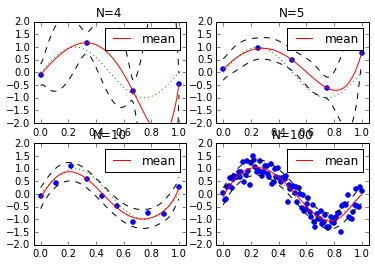

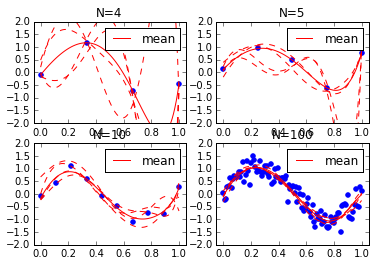

In [39]:
beta = 1.0/(0.3)**2     # 真の分布の分散
alpha = 1.0/100**2      # 事前分布の分散
order = 9               # 多項式の字数

# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2.0*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

# 事後分布に基づく推定曲線、および、事後分布の平均と分散を計算
def resolve(dataset, m):
    t = dataset.y
    phis = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phis = pd.concat([phis,p], axis=1)

    for index, line in phis.iterrows():
        phi = DataFrame(line)
        if index == 0:
            phiphi = np.dot(phi,phi.T)
        else:
            phiphi += np.dot(phi,phi.T)
    s_inv = alpha * DataFrame(np.identity(m+1)) + beta * phiphi
    s = np.linalg.inv(s_inv) # 事後分布の共分散行列

    # 平均 m(x)
    def mean_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        for index, line in phis.iterrows():
            if index == 0:
                tmp = t[index] * line
            else:
                tmp += t[index] * line
        return (beta * np.dot(np.dot(phi_x0.T, s), DataFrame(tmp))).flatten()

    # 標準偏差 s(x)
    def deviation_fun(x0):
        phi_x0 = DataFrame([x0 ** i for i in range(0,m+1)])
        deviation = np.sqrt(1.0/beta + np.dot(np.dot(phi_x0.T, s), phi_x0))
        return deviation.diagonal()

    for index, line in phis.iterrows():
        if index == 0:
            tmp = t[index] * line
        else:
            tmp += t[index] * line
    mean = beta * np.dot(s, DataFrame(tmp)).flatten() # 事後分布の平均

    return mean_fun, deviation_fun, mean, s

# Main
if __name__ == '__main__':
    df_ws = DataFrame()

    fig1 = plt.figure()
    fig2 = plt.figure()
    for c, num in enumerate([4,5,10,100]): # トレーニングセットのデータ数
        train_set = create_dataset(num)
        mean_fun, deviation_fun, mean, sigma = resolve(train_set, order)
        ws_samples = DataFrame(multivariate_normal(mean,sigma,4))

        subplot1 = fig1.add_subplot(2,2,c+1)
        subplot1.set_xlim(-0.05,1.05)
        subplot1.set_ylim(-2,2)
        subplot1.set_title("N=%d" % num)

        subplot2 = fig2.add_subplot(2,2,c+1)
        subplot2.set_xlim(-0.05,1.05)
        subplot2.set_ylim(-2,2)
        subplot2.set_title("N=%d" % num)

        # トレーニングセットを表示
        subplot1.scatter(train_set.x, train_set.y, marker='o', color='blue')
        subplot2.scatter(train_set.x, train_set.y, marker='o', color='blue')

        linex = np.arange(0,1.01,0.01)

        # 真の曲線を表示
        liney = np.sin(2*np.pi*linex)
        subplot1.plot(linex, liney, color='green',linestyle=':')

        # 平均と標準偏差の曲線を表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        subplot1.plot(linex, m, color='red', label='mean')
        subplot1.legend(loc=1)
        subplot1.plot(linex, m-d, color='black', linestyle='--')
        subplot1.plot(linex, m+d, color='black', linestyle='--')

        # 多項式のサンプルを表示
        m = np.array(mean_fun(linex))
        d = np.array(deviation_fun(linex))
        liney = m
        subplot2.plot(linex, liney, color='red', label="mean")
        subplot2.legend(loc=1)

        def f(x, ws):
            y = 0
            for i, w in enumerate(ws):
                y += w * (x ** i)
            return y

        for index, ws in ws_samples.iterrows():
            liney = f(linex, ws)
            subplot2.plot(linex, liney, color='red', linestyle='--')

    fig1.show()
    fig2.show()


* 緑の破線がy=sin(2*pi*x)
* 赤い線がy=m(x)
* 赤い破線がy=m(x) +- sqrt(s(x))

# 結果
* Nが少ない場合、y(x)はt(x)から外れることがある
        * それにともない分散も非常に大きい
* Nが大きい場合、分散もせばまり、標準偏差っぽくなる。
* オーバーフィッティングが抑えられている。
* 観測点x(n)でないとｋ